<a href="https://colab.research.google.com/github/sextonemmett/Computational_and_Deep_Learning/blob/main/01_Patient_outcome_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install category_encoders
!pip install imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.0 MB/s eta 0:00:00


In [ ]:
from datetime import datetime
import pandas as pd
import numpy as np
import category_encoders as ce
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbPipe
from sklearn.linear_model import BayesianRidge
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
import matplotlib.pylab as plt
from numpy import random
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
import pickle
import os

In [ ]:
# Load data
df_train = pd.read_csv('/content/drive/MyDrive/Trimester 2/04_Deep_learning_ML/Project 1/mimic_train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Trimester 2/04_Deep_learning_ML/Project 1/mimic_test_death.csv')

In [ ]:
# Imbalanced target variable. We will do some resampling during training to correct for this
Counter(df_train['HOSPITAL_EXPIRE_FLAG'])

Counter({0: 18540, 1: 2345})

In [ ]:
# Store test ids for predictions
test_ids = df_test['icustay_id']

In [ ]:
# Load meta data with additional diagnoses
meta = pd.read_csv('/content/drive/MyDrive/Trimester 2/04_Deep_learning_ML/Project 1/MIMIC_diagnoses.csv')

(array([ 374.,    0., 1057.,    0., 2799.,    0.,    0., 3278.,    0.,
        3507.,    0.,    0., 3712.,    0., 3875.,    0.,    0., 3967.,
           0., 9102.,    0.,    0., 2712.,    0., 2669.,    0., 2544.,
           0.,    0., 2334.,    0., 2235.,    0.,    0., 2005.,    0.,
        1865.,    0.,    0., 1708.,    0., 1461.,    0.,    0., 1287.,
           0., 1106.,    0.,  942.,    0.,    0.,  747.,    0.,  642.,
           0.,    0.,  510.,    0.,  416.,    0.,    0.,  373.,    0.,
         297.,    0.,    0.,  272.,    0.,  203.,    0.,  194.,    0.,
           0.,  138.,    0.,  118.,    0.,    0.,  103.,    0.,   61.,
           0.,    0.,   65.,    0.,   65.,    0.,    0.,   36.,    0.,
          30.,    0.,  120.]),
 array([ 1.        ,  1.40860215,  1.8172043 ,  2.22580645,  2.6344086 ,
         3.04301075,  3.4516129 ,  3.86021505,  4.2688172 ,  4.67741935,
         5.08602151,  5.49462366,  5.90322581,  6.31182796,  6.72043011,
         7.12903226,  7.53763441,  7.946

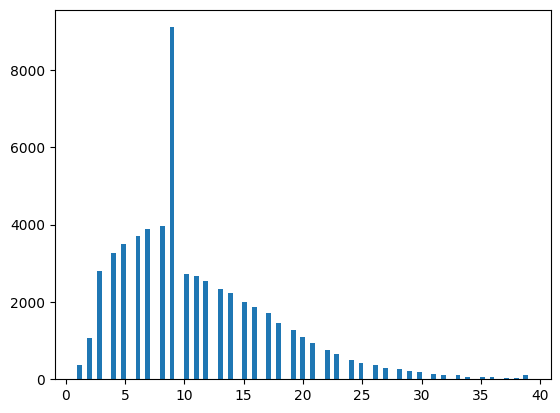

In [ ]:
# Reshape meta data wide
meta = meta.dropna(subset=['SEQ_NUM', 'ICD9_CODE'], how='all')

pivoted_diagnoses = meta.pivot(
    index=['SUBJECT_ID', 'HADM_ID'],
    columns='SEQ_NUM',
    values='ICD9_CODE'
).reset_index()

# Rename columns for clarity
pivoted_diagnoses.columns = [f'ICD9_{col}' if col not in ['SUBJECT_ID', 'HADM_ID'] else col for col in pivoted_diagnoses.columns]

# Add variable for number of diagnoses
extra_diag = pivoted_diagnoses.iloc[:, :11].copy()
extra_diag['diag_count'] = pivoted_diagnoses.iloc[:, 2:].notna().sum(axis=1)

# Check how distribution for number of diagnoses
plt.hist(extra_diag['diag_count'], bins='auto')

In [ ]:
# Add additional diagnoses to training and test data
df_train = pd.merge(
    df_train,
    extra_diag,
    how='left',
    left_on=['subject_id', 'hadm_id'],
    right_on=['SUBJECT_ID', 'HADM_ID']
)

df_test = pd.merge(
    df_test,
    extra_diag,
    how='left',
    left_on=['subject_id', 'hadm_id'],
    right_on=['SUBJECT_ID', 'HADM_ID']
)

In [ ]:
# Double check that the first diagnosis is the same as diagnosis from the test and train data
print(sum(df_train['ICD9_diagnosis'] == df_train['ICD9_1.0']))
print(sum(df_test['ICD9_diagnosis'] == df_test['ICD9_1.0']))

20885
5221


# Initial look at data

In [ ]:
# Double check ids
unique_ids = df_train[['subject_id', 'hadm_id', 'icustay_id']].nunique()
unique_ids

subject_id    16317
hadm_id       19749
icustay_id    20885
dtype: int64

In [ ]:
# Remove ID columns that we won't use for model training and columns in the training data not known for testing
df_train = df_train.drop(columns = ['subject_id', 'hadm_id', 'icustay_id', 'DOD','DISCHTIME', 'DEATHTIME', 'LOS', 'ICD9_diagnosis'])
df_test  = df_test.drop(columns  = ['subject_id', 'hadm_id', 'icustay_id', 'ICD9_diagnosis'])

In [ ]:
# Check data
print(df_train.shape)
print(df_test.shape)

(20885, 48)
(5221, 47)


In [ ]:
df_train.dtypes

HOSPITAL_EXPIRE_FLAG      int64
HeartRate_Min           float64
HeartRate_Max           float64
HeartRate_Mean          float64
SysBP_Min               float64
SysBP_Max               float64
SysBP_Mean              float64
DiasBP_Min              float64
DiasBP_Max              float64
DiasBP_Mean             float64
MeanBP_Min              float64
MeanBP_Max              float64
MeanBP_Mean             float64
RespRate_Min            float64
RespRate_Max            float64
RespRate_Mean           float64
TempC_Min               float64
TempC_Max               float64
TempC_Mean              float64
SpO2_Min                float64
SpO2_Max                float64
SpO2_Mean               float64
Glucose_Min             float64
Glucose_Max             float64
Glucose_Mean            float64
GENDER                   object
DOB                      object
ADMITTIME                object
Diff                    float64
ADMISSION_TYPE           object
INSURANCE                object
RELIGION

# Investigate categorical variables

In [ ]:
# Extract year of birth from date of birth variable
df_train['YOB'] = pd.to_datetime(df_train['DOB']).dt.year
df_test['YOB'] = pd.to_datetime(df_test['DOB']).dt.year

(array([128.,  19.,  11.,  11.,  11.,   7.,  17.,  23.,  24.,  21.]),
 array([  1. ,  23.4,  45.8,  68.2,  90.6, 113. , 135.4, 157.8, 180.2,
        202.6, 225. ]),
 <BarContainer object of 10 artists>)

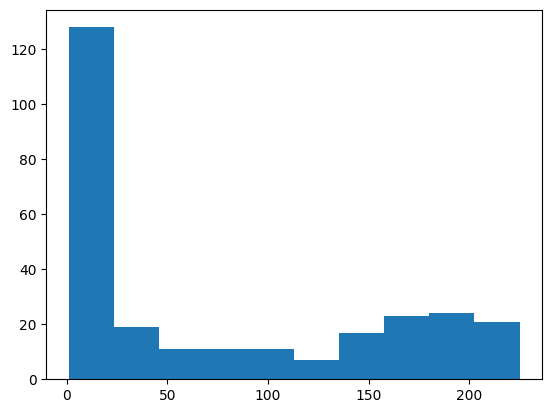

In [ ]:
yob_cnts = df_train['YOB'].value_counts()
plt.hist(yob_cnts, bins='auto')

In [ ]:
# Given the large number of values, I will use target encoding with smoothing for diagnosis
cat_feat = ['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'FIRST_CAREUNIT', 'ICD9_1.0']
for column in df_train[cat_feat]:
    print(f"{column} : {len(df_train[column].value_counts())}")

GENDER : 2
ADMISSION_TYPE : 3
INSURANCE : 5
RELIGION : 17
MARITAL_STATUS : 7
ETHNICITY : 41
FIRST_CAREUNIT : 5
ICD9_1.0 : 1853


In [ ]:
cat_feat = ['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'FIRST_CAREUNIT', 'ICD9_1.0']
for column in df_test[cat_feat]:
    print(f"{column} : {len(df_test[column].value_counts())}")

GENDER : 2
ADMISSION_TYPE : 3
INSURANCE : 5
RELIGION : 16
MARITAL_STATUS : 7
ETHNICITY : 37
FIRST_CAREUNIT : 5
ICD9_1.0 : 1024


In [ ]:
cat_feat = ['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'FIRST_CAREUNIT']
for c in cat_feat:
    print(f'{c}:')
    print(sorted(df_train[c].unique()))

GENDER:
['F', 'M']
ADMISSION_TYPE:
['ELECTIVE', 'EMERGENCY', 'URGENT']
INSURANCE:
['Government', 'Medicaid', 'Medicare', 'Private', 'Self Pay']
RELIGION:
['7TH DAY ADVENTIST', 'BUDDHIST', 'CATHOLIC', 'CHRISTIAN SCIENTIST', 'EPISCOPALIAN', 'GREEK ORTHODOX', 'HEBREW', 'HINDU', "JEHOVAH'S WITNESS", 'JEWISH', 'MUSLIM', 'NOT SPECIFIED', 'OTHER', 'PROTESTANT QUAKER', 'ROMANIAN EAST. ORTH', 'UNITARIAN-UNIVERSALIST', 'UNOBTAINABLE']
FIRST_CAREUNIT:
['CCU', 'CSRU', 'MICU', 'SICU', 'TSICU']


In [ ]:
ethnicity_counts = df_train['ETHNICITY'].value_counts()
ethnicity_counts

WHITE                                                       15112
BLACK/AFRICAN AMERICAN                                       1977
UNABLE TO OBTAIN                                              577
UNKNOWN/NOT SPECIFIED                                         568
HISPANIC OR LATINO                                            562
OTHER                                                         489
ASIAN                                                         265
PATIENT DECLINED TO ANSWER                                    175
HISPANIC/LATINO - PUERTO RICAN                                155
ASIAN - CHINESE                                               146
BLACK/CAPE VERDEAN                                            126
WHITE - RUSSIAN                                               117
BLACK/HAITIAN                                                  72
HISPANIC/LATINO - DOMINICAN                                    59
ASIAN - ASIAN INDIAN                                           58
WHITE - OT

In [ ]:
# Creating the alternative ethnicity labels by collapsing subgroups to avoid overfitting less populated ethnicities
df_train['alt_ethnicity'] = df_train['ETHNICITY'].apply(lambda x: x.split(' - ')[0])
df_train['alt_ethnicity'] = df_train['alt_ethnicity'].replace(regex={r'^BLACK.*': 'BLACK/AFRICAN AMERICAN'})
df_train['alt_ethnicity'] = df_train['alt_ethnicity'].replace({'UNABLE TO OBTAIN': 'UNKNOWN/NOT SPECIFIED'})
df_train['alt_ethnicity'] = df_train['alt_ethnicity'].replace({'HISPANIC/LATINO': 'HISPANIC OR LATINO'})

# List of remaining ethnicity groups that have high frequency
specified_ethnicities = ["WHITE", "BLACK/AFRICAN AMERICAN", "UNKNOWN/NOT SPECIFIED",
                         "HISPANIC OR LATINO", "ASIAN", "OTHER", "PATIENT DECLINED TO ANSWER"]

# Replacing all remaining low frequency values with "OTHER"
df_train['alt_ethnicity'] = df_train['alt_ethnicity'].apply(lambda x: x if x in specified_ethnicities else "OTHER")
# I'll one-hot encode this simplified variable
df_train['alt_ethnicity'].value_counts()

WHITE                         15330
BLACK/AFRICAN AMERICAN         2201
UNKNOWN/NOT SPECIFIED          1145
HISPANIC OR LATINO              852
OTHER                           637
ASIAN                           545
PATIENT DECLINED TO ANSWER      175
Name: alt_ethnicity, dtype: int64

In [ ]:
# Creating the alternative ethnicity labels by collapsing subgroups in df_test
df_test['alt_ethnicity'] = df_test['ETHNICITY'].apply(lambda x: x.split(' - ')[0])
df_test['alt_ethnicity'] = df_test['alt_ethnicity'].replace(regex={r'^BLACK.*': 'BLACK/AFRICAN AMERICAN'})
df_test['alt_ethnicity'] = df_test['alt_ethnicity'].replace({'UNABLE TO OBTAIN': 'UNKNOWN/NOT SPECIFIED'})
df_test['alt_ethnicity'] = df_test['alt_ethnicity'].replace({'HISPANIC/LATINO': 'HISPANIC OR LATINO'})

# List of remaining ethnicity groups that have high frequency
specified_ethnicities = ["WHITE", "BLACK/AFRICAN AMERICAN", "UNKNOWN/NOT SPECIFIED",
                         "HISPANIC OR LATINO", "ASIAN", "OTHER", "PATIENT DECLINED TO ANSWER"]

# Replacing all remaining low frequency values with "OTHER" in df_test
df_test['alt_ethnicity'] = df_test['alt_ethnicity'].apply(lambda x: x if x in specified_ethnicities else "OTHER")

# Missingness and imputation

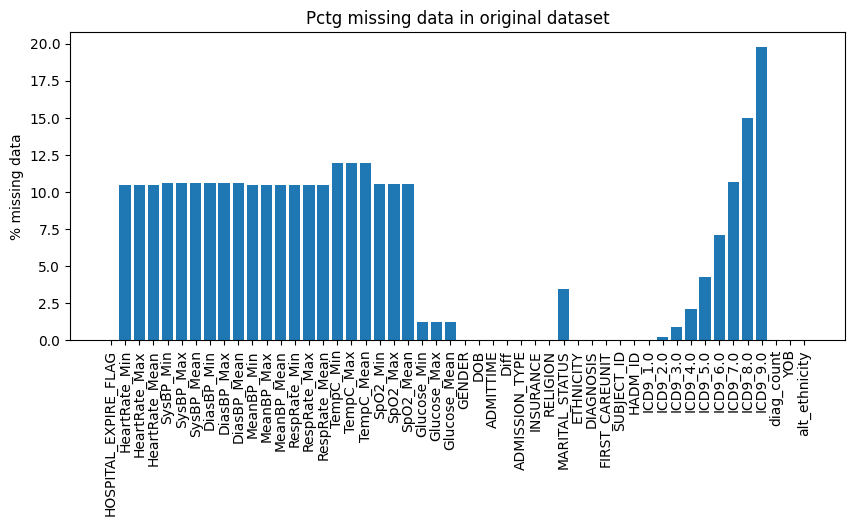

In [ ]:
# Plot missingness for train data
Nulls= df_train.isnull().sum()
x_vals = Nulls.index
y_vals = 100*Nulls.values/len(df_train.index)

plt.figure(figsize=(10,4))
plt.xticks(rotation='vertical')
plt.bar(x_vals, y_vals)
plt.ylabel('% missing data')
plt.title('Pctg missing data in original dataset')
plt.show()

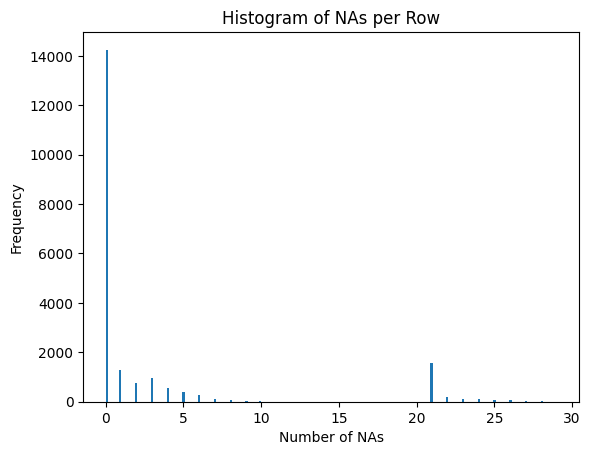

In [ ]:
# Most entries have less than 10 variables missing, while ~10% of entries have more than 20 missing
na_count_per_row = df_train.isna().sum(axis=1)

# Plotting the histogram
plt.hist(na_count_per_row, bins='auto')
plt.title('Histogram of NAs per Row')
plt.xlabel('Number of NAs')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Drop columns no longer needed in features data
df_train_pre_trans = df_train.drop(columns = ['DOB', 'HOSPITAL_EXPIRE_FLAG', 'ADMITTIME', 'Diff', 'DIAGNOSIS', 'ETHNICITY']).copy()
df_test_pre_trans  = df_test.drop(columns  = ['DOB', 'ADMITTIME', 'Diff', 'DIAGNOSIS', 'ETHNICITY']).copy()

In [ ]:
# Flag rows that are heavily missing
df_train_pre_trans['missing_20_or_more'] = df_train_pre_trans.apply(lambda row: 1 if row.isna().sum() >= 20 else 0, axis=1)
df_test_pre_trans['missing_20_or_more'] = df_test_pre_trans.apply(lambda row: 1 if row.isna().sum() >= 20 else 0, axis=1)

# We will impute this using the most frequent, but will also flag it because its the only missing categorical variable besides the diagnoses
df_train_pre_trans['flag_miss_marital'] = df_train_pre_trans['MARITAL_STATUS'].isna().astype(int)
df_test_pre_trans['flag_miss_marital'] = df_test_pre_trans['MARITAL_STATUS'].isna().astype(int)

# Model tuning

In [ ]:
y_train = df_train['HOSPITAL_EXPIRE_FLAG']
X_train = df_train_pre_trans.copy()
X_test  = df_test_pre_trans.copy()

## K-Nearest Neighbors

In [ ]:
# Define the column selectors for different types of columns
categorical_cols = ['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'FIRST_CAREUNIT', 'alt_ethnicity']
numeric_cols = df_train_pre_trans.select_dtypes(include='number').columns.to_list()
# I target encode the first 9 entries because they are the most populated/to avoid overfitting the less populated diagnoses from the meta data
diagnoses = ['ICD9_1.0', 'ICD9_2.0', 'ICD9_3.0', 'ICD9_4.0', 'ICD9_5.0', 'ICD9_6.0', 'ICD9_7.0', 'ICD9_8.0', 'ICD9_9.0']

# Target encode diagnoses with smoothing.
# I experimented with smoothing values of [1, 3, 5, 10, 15, 20, 25, 30] and min_samples_leaf of [1:20]
target_encode = Pipeline(steps=[
    ('target_encoder', TargetEncoder(smoothing=50, min_samples_leaf = 5))
])

# Impute and one-hot encode other categorical variables
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Impute missing numeric variables using BayesianRidge
numeric_transformer = Pipeline(steps=[
    ('imputer', IterativeImputer(estimator=BayesianRidge(), random_state=3))
])

# ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('target', target_encode, diagnoses),
    ('cat', categorical_transformer, categorical_cols),
    ('num', numeric_transformer, numeric_cols)],
    remainder='drop')

# Full pipeline with SMOTE to balance target class in training
pipeline = imbPipe(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=3)),
    ('classifier', KNeighborsClassifier())
])

# GridSearchCV for parameter tuning
  # I experimented with this grid follwed by the next one
  # param_grid = {
  #     'classifier__n_neighbors': [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
  #     'classifier__weights': ['uniform','distance'],
  #     'classifier__algorithm': ['auto'],
  #     'classifier__metric': ['minkowski'],
  #     'classifier__p': [1.5,2,2.5,3]
  # }

    # param_grid = {
  #     'classifier__n_neighbors': [750, 775, 800, 825, 850, 875, 900],
  #     'classifier__weights': ['distance'],
  #     'classifier__algorithm': ['auto'],
  #     'classifier__metric': ['minkowski'],
  #     'classifier__p': [2]
  # }


param_grid = {
    'classifier__n_neighbors': [700, 800, 900, 1000],
    'classifier__weights': ['distance'],
    'classifier__algorithm': ['auto'],
    'classifier__metric': ['minkowski'],
    'classifier__p': [2]
}

knn_grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc')

In [ ]:
# Fit KNN on training data
knn_grid_search.fit(X_train, y_train)

print("Best parameters:", knn_grid_search.best_params_)
print("Best score:", knn_grid_search.best_score_)

base_directory = '/content/drive/MyDrive/Trimester 2/04_Deep_learning_ML/Project 1/'
file_path = os.path.join(base_directory, 'model_knn_825.pickle')
pickle.dump(knn_grid_search, open(file_path, 'wb'))

Best parameters: {'classifier__algorithm': 'auto', 'classifier__metric': 'minkowski', 'classifier__n_neighbors': 1000, 'classifier__p': 2, 'classifier__weights': 'distance'}
Best score: 0.8853421289300147


In [ ]:
knn_model =  pickle.load(open(file_path, 'rb'))

In [ ]:
# Save KNN predictions for test
knn_predictions = knn_model.predict_proba(X_test)
knn_prob_death = pd.DataFrame({'HOSPITAL_EXPIRE_FLAG':knn_predictions[:,1]})
knn_submission = pd.concat([test_ids, knn_prob_death], axis=1)
knn_submission.to_csv('/content/drive/MyDrive/Trimester 2/04_Deep_learning_ML/Project 1/KNN prob predictions - 825 NN.csv', index=False)

## Support Vector Classifier

In [ ]:
# I used samples of the data to find the rough area of the best parameters and then did my grid searches over those areas on the full data because of the long run times
# The range of hyperparameters considered were far larger using this method than the grid search used in the final pipeline, which represents the narrowed down search

  # random.seed(3)

  # n_subset = 4000
  # ind_subset = random.choice(X_train.shape[0], size= n_subset, replace=False)## indicies of your sampled points

  # sub_X_train = X_train.copy().iloc[ind_subset,]## selecting the subsampled indicies
  # sub_y_train = y_train[ind_subset]
  # print(sub_X_train.shape)
  # print(sub_y_train.shape)

(4000, 46)
(4000,)


In [ ]:
# Define the column selectors for different types of columns
categorical_cols = ['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'FIRST_CAREUNIT', 'alt_ethnicity']
numeric_cols = df_train_pre_trans.select_dtypes(include='number').columns.to_list()
diagnoses = ['ICD9_1.0', 'ICD9_2.0', 'ICD9_3.0', 'ICD9_4.0', 'ICD9_5.0', 'ICD9_6.0', 'ICD9_7.0', 'ICD9_8.0', 'ICD9_9.0']

# Target encode diagnoses with smoothing
target_encode = Pipeline(steps=[
    ('target_encoder', TargetEncoder(smoothing=20, min_samples_leaf = 5))
])

# Impute and one-hot encode other categorical variables
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Impute missing numeric variables using BayesianRidge
numeric_transformer = Pipeline(steps=[
    ('imputer', IterativeImputer(estimator=BayesianRidge(), random_state=3))
])

# ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('target', target_encode, diagnoses),
    ('cat', categorical_transformer, categorical_cols),
    ('num', numeric_transformer, numeric_cols)],
    remainder='drop')

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('classifier', SVC())
])

# GridSearchCV for parameter tuning
param_grid = {
    'classifier__class_weight':['balanced'],
    'classifier__probability': [True],
    'classifier__random_state': [3],
    'classifier__C': [0.05, 0.1, 0.15, 0.2],
    'classifier__kernel': ['poly', 'rbf', 'sigmoid'],
    'classifier__degree': [1,2,3,4],
    'classifier__gamma': ['auto'],
    'classifier__coef0': [-1, 0, 1, 2]
}

svc_grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc')

In [ ]:
# Fit SVC on training data
svc_grid_search.fit(X_train, y_train)

print("Best parameters:", svc_grid_search.best_params_)
print("Best score:", svc_grid_search.best_score_)

base_directory = '/content/drive/MyDrive/Trimester 2/04_Deep_learning_ML/Project 1/'
file_path = os.path.join(base_directory, 'model_svc_sig.pickle')
pickle.dump(svc_grid_search, open(file_path, 'wb'))

Best parameters: {'classifier__C': 0.1, 'classifier__class_weight': 'balanced', 'classifier__coef0': 1, 'classifier__degree': 2, 'classifier__gamma': 'auto', 'classifier__kernel': 'poly', 'classifier__probability': True, 'classifier__random_state': 3}
Best score: 0.9045938821840865


In [ ]:
base_directory = '/content/drive/MyDrive/Trimester 2/04_Deep_learning_ML/Project 1/'
file_path = os.path.join(base_directory, 'model_svc_poly_C_01_deg_2.pickle')
svc_grid_search = pickle.load(open(file_path, 'rb'))

In [ ]:
# Save SVC predictions
svc_predictions = svc_grid_search.predict_proba(X_test)
svc_prob_death = pd.DataFrame({'HOSPITAL_EXPIRE_FLAG':svc_predictions[:,1]})
svc_submission = pd.concat([test_ids, svc_prob_death], axis=1)
svc_submission.to_csv('/content/drive/MyDrive/Trimester 2/04_Deep_learning_ML/Project 1/SVM prob predictions poly.csv', index=False)